##This notebook is used to demultiplex the sequencing run into the corresponding samples, according to their barcodes

In [1]:
# Imports all the necessary programs
# screed for making databases
# pandas, which is a library of Python data analysis functions
# Counter tool for convenient and rapid tallies
# matplotlib for plotting
# numpy for basic computing in Python
# mpltools are more tools for matplotlib
import screed
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from mpltools import style

/opt/virt_env/lib/python2.7/site-packages/mpltools/style/__init__.py:42: FutureWarning: 

    The style-sheet functionality in mpltools has been integrated into
    Matplotlib >= 1.4. This module will be removed in a future release.

    Note that style-sheets used by `matplotlib.style` use the standard
    Matplotlib rc-file syntax instead of the INI format used by `mpltools`.
    This mostly means un-quoting strings and changing '=' to ':'.


  """, FutureWarning)


In [2]:
# sets our style parameters to ggplot
style.use("ggplot")

In [3]:
# tells the notebook to show the output (graphics) from matplotlib inline (in the notebook)
%matplotlib inline

In [4]:
# This step unzips our index read fastq file.
!pigz -k -d -p 4 ../../SeqData/Undetermined_S0_L001_I1_001.fastq.gz
# -k means keep the original, -d means decompress the input, -p means use this number of processors

###Creating our databases to compare index file with sequence file

In [5]:
# This creates the database which it will query
# The database will have the sequence name, description, quality, and sequence itself (if those data are in the original files)
# The output will be the same file with NAME_screed
screed.read_fastq_sequences("../../SeqData/Undetermined_S0_L001_I1_001.fastq")

<ScreedDB, '../../SeqData/Undetermined_S0_L001_I1_001.fastq_screed'>

In [6]:
# tells the notebook where our index reads are
ir1 = "../../SeqData/Undetermined_S0_L001_I1_001.fastq"

In [7]:
# Loads our index reads database created above
ir1db = screed.ScreedDB(ir1)

In [232]:
# locating the tab delimited file with the index reads and the sample IDS
# Note that 0,1,2,3,4 are just row numbers
# I need to make this file in excel - note that barcodes as given by Tong need to be reverse-complemented.
# This step is making that information into a data frame (using panda), called df_map
# Note that the first items are identified by a "0" (Python uses a 0-index)
# Also note that the first column was made up by the program - not present in the initial file.
df_map = pd.read_csv("../../SeqData/MapFile.txt", delimiter="\t", usecols=[0,1], names=["i1","SampleID"])
# uses Pandas to read our csv file of our sequence data.
# We only had one indexed read, so we just use that.
# prints the head of the dataframe we made called df_map
df_map[1:4]

,i1,SampleID
1,1,TGTTATCGCACA
2,2,CTTACACCAAGT
3,3,AGTTCCCGAGTA


In [238]:
# map calls a function (lambda) for a sequence of items (zipped)
# lambda creates a function, into which x is input. 
# Here, we are getting whatever x was at 0, 1, and 2 (so the first three columns of our data), and adding the first two
# together (our indicies), and maintaining the second one (our sample IDs).
# "Zipping" links together three elements of the same length, effectively creating an array of vectors
# So, here, we have linked together the columns in our mapping dataframe, df_map.
# Basically, we link together the three columns, using zip, and then we concatenate the first two values
# at each place and keep the last one separate, using the lambda function we created here.
# This happens using the map function - the function called is defined by lambda, the sequence of items we look at 
# is defined by the zip function
# Dict is a data structure in Python, the "dictionary"
# A dictionary has unique keys that are linked to other data
# Here we are using our map output to make the dictionary. The map created two values - our combined indicies and ID.
# Thus, the map_d.keys at a given position will be the combined index primers,
# and the map_d returned when the map_d.keys at a given position is input, will be our sample ID.
map_d = dict(map(lambda x: (x[0], x[1]), zip(df_map.SampleID,df_map.i1,)))
print map_d.keys()[20], map_d[map_d.keys()[20]]

AAGGGAGGAGAC 93


In [241]:
map_d['TACTTCGCTCGC']

'67.2'

In [18]:
# We already created the database with our merged sequence files in merge_reads
# The output will be the same file with NAME_screed
# screed.read_fastq_sequences("../../SeqData/pear_merged-2015-07-03.assembled.fastq")

<ScreedDB, '../../SeqData/pear_merged-2015-06-30.assembled.fastq_screed'>

In [265]:
# Loads the screed database
db = screed.ScreedDB("../../SeqData/pear_merged-2015-07-03.assembled.fastq_screed")

### Beware: the script below will overwrite your fastq file - make sure it works before running it!

In [266]:
# Sets a counting index and starts the number of unassigned reads at zero.
# Defines our output as our fastq file.
# Sets up a counter function, which is actually like a dictionary.
# Assigns our assembled sequence data
counter = 0
unassigned = 0
cnt = Counter()
fq = "../../SeqData/pear_merged-2015-07-13.assembled.fastq"

# "w" means we are opening the file to "w"rite
with open(fq, "w") as out:
# for each record in our database (of sequence reads, est. above) that we go through iteratively...
  for rec in db.itervalues(): 
        # We get the name of this record, and then find that same name in our index db, and get the associated sequence
        index = ir1db[rec["name"]]["sequence"]
        # We take the index sequence found above (matching the sample's name), and find it in our map file
        # This should spit out the ID of the sample associated with these indicies, which we then join to
        # an underscore, and the current counter value (which number sequence is this?)
        try:
            new_name = map_d[index] + "_" + str(counter) #case sensitive
            # If we couldn't find the index name in our dictionary map file, we say it was unassigned, and tally it.
        except KeyError:
            unassigned += 1
            continue
            # Resetting to continue
        counter += 1
        # map_d[index_etc.lower] should give us the sample name we assigned to that index set.
        # We feed that into the counter - not quite sure what happens
        # We also increase [what?] by 1.
        cnt[map_d[index]] += 1 #case sensitive
        # We define s and q as the sequence and accuracy values (from our screed db) 
        s, q = rec["sequence"], rec["quality"]
        # The output written to the file we called fn will be all this..not quite sure what's going on.
        out.write("@%s orig_name=%s\n%s\n+\n%s\n"%(new_name,rec["name"],s,q))
        # Reports how many reads didn't match the mapping file. Note that we require an exact match here.
print "Unable to assign %s reads to samples"%unassigned
# The final output should be still a fastq file but now with the sample ID attached.
# For now it is called pear_merged-2014-03-25.assembled.demult.fastq

Unable to assign 6348429 reads to samples


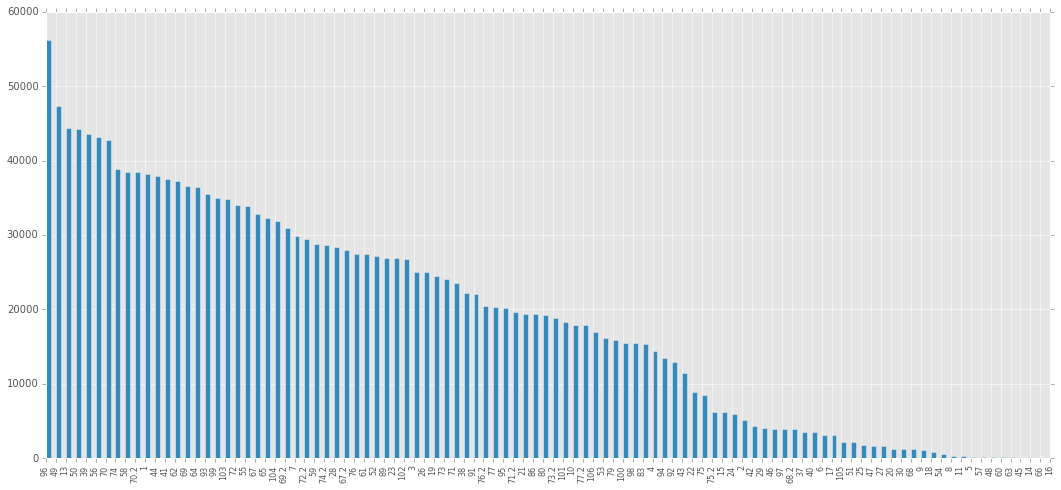

In [267]:
# Makes a plot of read counts organized by index
# Seems like it worked okay - lowest 12 reads <50,000 counts.
X = np.arange(len(cnt.keys()))
Y = [v for k, v in cnt.most_common()]
fig = plt.figure()
fig.set_size_inches((18,8))
ax = fig.add_subplot(111)
bars = ax.bar(X, Y, width=0.5)
xlims = ax.set_xlim((X.min(), X.max()))
xt = ax.set_xticks(X)

xtl = ax.set_xticklabels([k for k, v in cnt.most_common()], rotation=90, ha="center", size=8)

In [131]:
!grep 'ATGGTTGTTGGC' ../../SeqData/20150624_I1_001.fasta

ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC

I tried searching for a barcode in the sequencing data as well, forward, backwards, and complemented each way. It only turned up in one sequence, and it seemed pretty clearly just a random part of the sequence - it was in the middle. However, I was able to find it flipped and reverse-complemented in the index file after all. Yay!